## ReAct Agent Architecture.
For context, look at the last part of `chatbot_with_tools.ipynb`

The only change we are going to do to the old code is the structure of the langgraph.

In [1]:
from typing import Annotated 
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 

class AgentState(TypedDict):
    """Messages are of type list, and the annotation defines how the list is updated
    In this case, the add_messages reducer is telling it to append new messages to the list instead of replacing it.
    """
    messages: Annotated[list, add_messages]
    
graph = StateGraph(AgentState)



import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()  

llm = ChatGroq(
    model_name=os.getenv("MODEL_NAME"),
    api_key=os.getenv("GROQ_API_KEY") 
)


In [2]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)

## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)


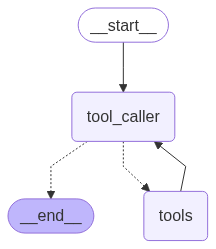

In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
# build graph
graph = StateGraph(AgentState)

# define tolnodes
def tool_caller(state:AgentState) -> AgentState:
    """This node calls tools and appends the results to the messages list."""
    return {
        "messages":state["messages"] + [llm_with_tool.invoke(state["messages"])]
        }

# add nodes
graph.add_node("tool_caller", tool_caller)
graph.add_node("tools", ToolNode(tools))



# add edges conditionally
graph.add_edge(START, "tool_caller")
graph.add_conditional_edges(
    "tool_caller", 
    # if the last message in messages is a tool call, go to tools node
    tools_condition,
    # if the last message is not a tool call, go to END node
    END
)
graph.add_edge("tools", "tool_caller")

# compile graph
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
response=app.invoke({"messages":"Tell me the recent ai news and then multiply 5 by 10"})

In [11]:
for line in response["messages"][-1].content.split("\n"):
    print(line.strip())

Based on the output from the "tavily_search" tool, the recent AI news is about OpenAI teasing the imminent launch of GPT-5, a new AI model that is expected to be more powerful and capable than its predecessors. Additionally, there are news articles about other AI-related developments in the fintech industry, such as April's Series B funding and Lloyds' AI strategy.

Now, to multiply 5 by 10, I can simply use the mathematical operation:

5 * 10 = 50

So the result of multiplying 5 by 10 is 50.


Clearly, we have achieved a solution to the problem faced with the previous architecture using this.

PREVIOUS
```mermaid
    flowchart TD
    A[Query] --> B[LLM]
    B[LLM] --> C[Tool Node]
    C[Tool Node] --> END
    B[LLM] --> END
```

ReAct AGENT
```mermaid
    flowchart TD
    A[Query] --> B[LLM]
    B[LLM] --> C[Tool Node]
    C[Tool Node] --> B[LLM]
    B[LLM] --> END
```